# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
!pip install kmodes
from kmodes.kmodes import KModes
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn import preprocessing
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Look at the data shapes
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


In [4]:
# Load datasets with further feature information
dias_atts = pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx")
dias_vals = pd.read_excel("DIAS Attributes - Values 2017.xlsx", skiprows=1)
#dias_vals["Attribute"] = dias_vals["Attribute"].fillna(method='ffill')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [57]:
# Different data types in azdias
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [58]:
# Different data types in customers
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

In [5]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [6]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [12]:
# share of NAs in the azdias data
azdias.isna().sum().sum()/(891221*366)

0.10268016415595567

In [13]:
# share of NAs in the customers data
customers.isna().sum().sum()/(191652*369)

0.19604924734572832

**In the first dataset every tenth cell has an *NA* value while in the second dataset every fifth cell has an *NA* value**

In [59]:
# Take a closer look at the values of one column
azdias["AGER_TYP"].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

**It appears that *NA* values have been given a representative value here (in our case -1). A closer look at `dias_vals` reveals that such in the column `value` the representative designations are located. If you leave this out the number of *NAs* in some columns still seems very high**

In [60]:
# find out NA-encodings for every column
na_lookup = dias_vals[dias_vals["Attribute"].notna()].apply(lambda x: x[["Attribute", "Description", "Value", "Meaning"]] if ("unknown" in x["Meaning"]) else np.nan, axis = 1).dropna()
na_lookup["Value"] = na_lookup["Value"].astype(str)
na_lookup.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown


In [61]:
def encode_NAs(df):
    """Replaces representative NA designations by np.nan 

    Parameters:
    df (DataFrame): A DataFrame with "hidden" NAs 

    Returns:
    df (DataFrame): A DataFrame with "true" NAs (np.nan)

    """
    #df = df.astype(str)
    for col in na_lookup["Attribute"].values:
        if col in df.columns:
            #print(col)
            if df[col].dtypes != "object":
                df[col] = df[col].astype(float)
            for na in na_lookup.loc[na_lookup["Attribute"] == col, "Value"].values[0].split(", "):
                df[col] = df[col].replace(int(na), np.nan)
                df[col] = df[col].replace(na, np.nan)
    return df

In [62]:
# Replaces representative designations by np.nan
azdias = encode_NAs(azdias)
customers = encode_NAs(customers)

**Throughout this cleaning 10.6% more Nas have been found. Since the operations on the DataFrames take very long my goal is from now on to reduce the dimensions.**

In [63]:
# Sort columns by missing values
azdias_na = azdias.isna().sum().sort_values()
customers_na = customers.isna().sum().sort_values()

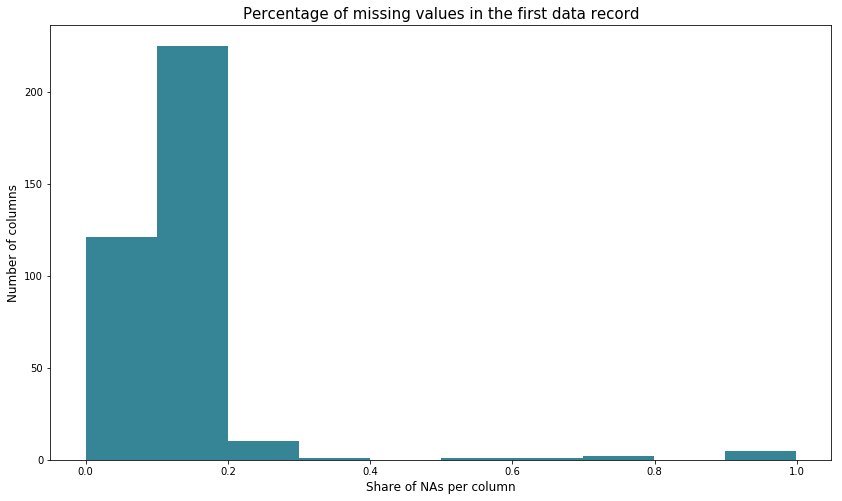

In [151]:
fig, ax = plt.subplots(figsize=(14,8))
ax.hist(azdias_na/len(azdias), color = "#358597")
plt.xlabel("Share of NAs per column", size = 12)
plt.ylabel("Number of columns", size = 12)
plt.title("Percentage of missing values in the first data record", size = 15);
plt.savefig("azdias.png", bbox_inches = 'tight');

Text(0,0.5,'Number of columns')

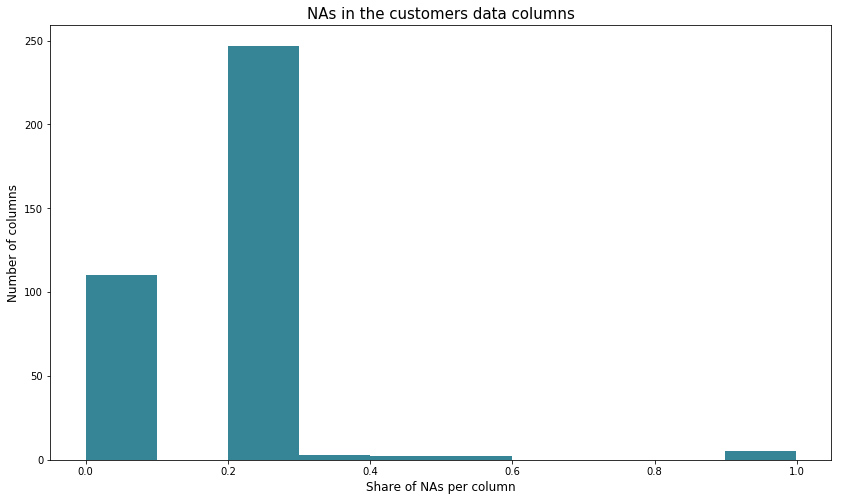

In [152]:
fig, ax = plt.subplots(figsize=(14,8))
ax.hist(customers_na/len(customers), color = "#358597")
plt.title("NAs in the customers data columns", size = 15)
plt.xlabel("Share of NAs per column", size = 12)
plt.ylabel("Number of columns", size = 12)

In [66]:
# Create two new datasets where the missing value proportion is <= 25% for both datasets
inter_col = list(set(azdias_na[azdias_na/len(azdias) <= 0.2].index).intersection(customers_na[customers_na/len(customers) <= 0.2].index))
azdias_new = azdias[inter_col]
customers_new = customers[inter_col]
print("Keeping {} columns.".format(len(inter_col)))

Keeping 107 columns.


In [67]:
# Forward Fill the "Attribute" column for easier investigation
dias_vals["Attribute"] = dias_vals["Attribute"].fillna(method='ffill')
pd.set_option('display.max_rows', None)
dias_vals[dias_vals["Attribute"].isin(inter_col)]

,Unnamed: 0,Attribute,Description,Value,Meaning
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,NaN,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,NaN,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,NaN,ALTERSKATEGORIE_GROB,NaN,4,> 60 years
10,NaN,ALTERSKATEGORIE_GROB,NaN,9,uniformly distributed
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
34,NaN,ANREDE_KZ,NaN,1,male
35,NaN,ANREDE_KZ,NaN,2,female
131,NaN,CJT_GESAMTTYP,customer journey typology,0,unknown


In [68]:
# how many unique values do the remaining columns have?
pd.reset_option('^display.', silent=True)
num_char = dias_vals[dias_vals["Attribute"].isin(inter_col)].groupby("Attribute")["Meaning"].count().sort_values(ascending = False)
print(num_char)

Attribute
LP_LEBENSPHASE_FEIN          40
GFK_URLAUBERTYP              12
LP_LEBENSPHASE_GROB          12
LP_FAMILIE_FEIN              11
D19_TELKO_DATUM              10
D19_GESAMT_ONLINE_DATUM      10
D19_GESAMT_OFFLINE_DATUM     10
D19_GESAMT_DATUM             10
D19_VERSAND_OFFLINE_DATUM    10
D19_VERSAND_DATUM            10
D19_BANKEN_ONLINE_DATUM      10
D19_BANKEN_OFFLINE_DATUM     10
D19_BANKEN_DATUM             10
LP_STATUS_FEIN               10
D19_TELKO_OFFLINE_DATUM      10
D19_TELKO_ONLINE_DATUM       10
D19_VERSAND_ONLINE_DATUM     10
SEMIO_MAT                     8
SEMIO_TRADV                   8
SEMIO_SOZ                     8
SEMIO_REL                     8
SEMIO_VERT                    8
SEMIO_RAT                     8
SEMIO_PFLICHT                 8
SEMIO_DOM                     8
SEMIO_KULT                    8
SEMIO_KRIT                    8
SEMIO_KAEM                    8
SEMIO_FAM                     8
SEMIO_ERL                     8
SEMIO_LUST                    

In [69]:
# delete the columns with unique values > 8 for easier clustering
num_char_cols = list(num_char[num_char <= 8].index)
azdias_new = azdias_new[num_char_cols]
customers_new = customers_new[num_char_cols]
print(azdias_new.shape)
print(customers_new.shape)

(891221, 42)
(191652, 42)


**`GEBURTSJAHR` seems to be the only *numeric* column left. If we take a closer look at the column, it is obvious that ~44% of the values have a 0. Since birth year == 0 is very unrealistic, these are NAs. Therefore this column is also deleted and we don't need to normalize any column. 41 columns remain on which a cluster analysis is performed. Since these are categorical columns, the mode is chosen to fill the remaining NAs.**

In [70]:
azdias_new = azdias_new.drop("GEBURTSJAHR", axis = 1)
customers_new = customers_new.drop("GEBURTSJAHR", axis = 1)

In [71]:
# Fill the missing values with the mode 
azdias_new.fillna(azdias_new.mode().iloc[0], inplace=True)
customers_new.fillna(customers_new.mode().iloc[0], inplace=True)

In [100]:
# k-modes (k-means for categorical data)
#costs = []
#for i in range(3,20):
#    km = KModes(n_clusters=i, max_iter = 100, init='Huang', n_init=5, verbose=1, n_jobs = -1)
#    clusters = km.fit_predict(customers_new)
#    costs.append(km.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 37513, cost: 2864630.0
Run 1, iteration: 2/100, moves: 11806, cost: 2858845.0
Run 1, iteration: 3/100, moves: 1560, cost: 2858845.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 37259, cost: 2898369.0
Run 2, iteration: 2/100, moves: 19192, cost: 2885004.0
Run 2, iteration: 3/100, moves: 11211, cost: 2871353.0
Run 2, iteration: 4/100, moves: 4350, cost: 2871353.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 49463, cost: 2874527.0
Run 3, iteration: 2/100, moves: 9293, cost: 2870875.0
Run 3, iteration: 3/100, moves: 94, cost: 2870875.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 65441, cost: 2992681.0
Run 4, iteration: 2/100, moves: 35622, cost: 2939621.0
Run 4, iteration: 3/100, m

Run 5, iteration: 2/100, moves: 21291, cost: 2502463.0
Run 5, iteration: 3/100, moves: 6710, cost: 2502463.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 87887, cost: 2477506.0
Run 1, iteration: 2/100, moves: 32594, cost: 2415753.0
Run 1, iteration: 3/100, moves: 8583, cost: 2411854.0
Run 1, iteration: 4/100, moves: 2457, cost: 2411854.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 54674, cost: 2474837.0
Run 2, iteration: 2/100, moves: 7366, cost: 2473521.0
Run 2, iteration: 3/100, moves: 4246, cost: 2467455.0
Run 2, iteration: 4/100, moves: 7854, cost: 2454159.0
Run 2, iteration: 5/100, moves: 8081, cost: 2446173.0
Run 2, iteration: 6/100, moves: 2913, cost: 2446173.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 71901, cost: 2465859.0
Run 3, iteration: 2/100, moves:

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 59799, cost: 2338024.0
Run 1, iteration: 2/100, moves: 11800, cost: 2333970.0
Run 1, iteration: 3/100, moves: 1733, cost: 2333970.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 65088, cost: 2377325.0
Run 2, iteration: 2/100, moves: 22800, cost: 2363370.0
Run 2, iteration: 3/100, moves: 7478, cost: 2361837.0
Run 2, iteration: 4/100, moves: 1327, cost: 2361837.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 45896, cost: 2368461.0
Run 3, iteration: 2/100, moves: 9106, cost: 2368461.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 52861, cost: 2324010.0
Run 4, iteration: 2/100, moves: 16521, cost: 2316933.0
Run 4, iteration: 3/100, moves: 2631, cost: 2315696.0
Run 4, iteration: 4/100, 

Starting iterations...
Run 5, iteration: 1/100, moves: 52399, cost: 2252962.0
Run 5, iteration: 2/100, moves: 15107, cost: 2247205.0
Run 5, iteration: 3/100, moves: 5858, cost: 2245210.0
Run 5, iteration: 4/100, moves: 993, cost: 2245210.0
Best run was number 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 61933, cost: 2230397.0
Run 1, iteration: 2/100, moves: 15831, cost: 2223421.0
Run 1, iteration: 3/100, moves: 6582, cost: 2216738.0
Run 1, iteration: 4/100, moves: 6241, cost: 2213907.0
Run 1, iteration: 5/100, moves: 704, cost: 2213907.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 84040, cost: 2236878.0
Run 2, iteration: 2/100, moves: 20592, cost: 2229994.0
Run 2, iteration: 3/100, moves: 5024, cost: 2228031.0
Run 2, iteration: 4/100, moves: 4111, cost: 2220052.0
Run 2, iteration: 5/100, moves: 4599, cost: 2218134.0
Run 2, iteration: 6/100, moves: 277

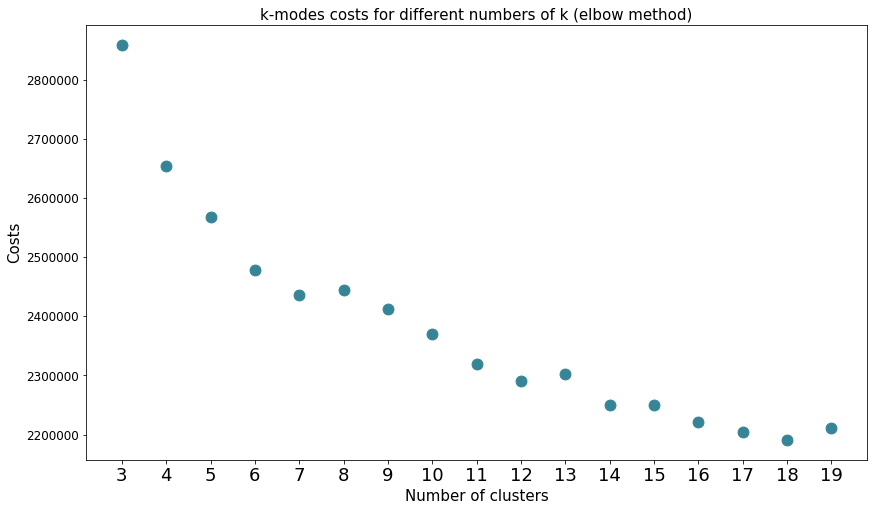

In [153]:
# plot the costs for different k from the evaluation above
costs = [2858845.0, 2653745.0, 2567683.0, 2478850.0, 2436607.0, 2444396.0, 2411854.0, 2369321.0, 2319466.0, 2290759.0, 2301800.0, 2250591.0, 2250030.0, 2221291.0, 2203731.0, 2190752.0, 2211381.0]

fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(range(3,20), costs, s = 118, color = "#358597")
plt.xticks(range(3,20), size = 18)
plt.xlabel("Number of clusters", size = 15)
plt.ylabel("Costs", size = 15)
plt.yticks(size = 12)

plt.title("k-modes costs for different numbers of k (elbow method)", size = 15);

In [148]:
# chose k = 7 and fit_predict on the customer_new DataFrame
km = KModes(n_clusters=7, max_iter = 100, init='Huang', n_init=20, verbose=1, n_jobs = -1)
clusters = km.fit_predict(customers_new)

In [99]:
# Predict for the azdias_new DataFrame
clusters_azdias_new = km.predict(azdias_new)

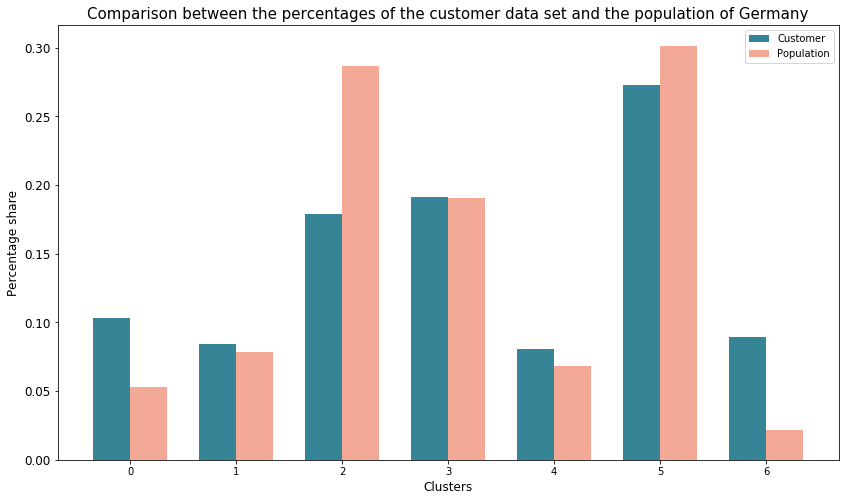

In [154]:
bar_width = 0.35
fig, ax = plt.subplots(figsize=(14,8))

ax.bar(np.unique(clusters, return_counts=True)[0], np.unique(clusters, return_counts=True)[1]/len(clusters), bar_width, label = "Customer", color = "#358597")
ax.bar(np.unique(clusters_azdias_new + bar_width, return_counts=True)[0], np.unique(clusters_azdias_new, return_counts=True)[1]/len(clusters_azdias_new), bar_width, label = "Population", color = "#f4a896")
plt.legend()
plt.xticks(np.arange(0,7)+bar_width/2, range(0,7))

plt.xlabel("Clusters", size = 12)
plt.ylabel("Percentage share", size = 12)
plt.yticks(size = 12)

plt.title("Comparison between the percentages of the customer data set and the population of Germany", size = 15)
plt.savefig("cluster_comparison.png", bbox_inches = 'tight');

In [22]:
# Print the cluster modes
print(km.cluster_centroids_)

[[ 5.  3.  2.  7.  1.  4.  5.  6.  3.  7.  6.  6.  3.  5.  0.  0.  0.  3.
   0.  4.  0.  0.  2.  0.  0.  0.  6.  0.  4.  5.  3.  3.  5.  3.  2.  3.
   1.  0.  2.  2.  0.]
 [ 2.  3.  2.  3.  4.  4.  3.  7.  3.  4.  7.  3.  6.  6.  0.  0.  0.  3.
   0.  6.  0.  0.  4.  0.  0.  0.  4.  0.  1.  1.  1.  4.  1.  5.  4.  5.
   3.  5.  5.  2.  0.]
 [ 1.  4.  6.  3.  6.  3.  2.  3.  4.  3.  3.  5.  7.  7.  0.  0.  0.  3.
   0.  2.  0.  0.  4.  0.  0.  0.  2.  0.  1.  1.  2.  5.  1.  5.  2.  5.
   4.  5.  4.  1.  0.]
 [ 1.  1.  2.  1.  4.  3.  2.  5.  1.  6.  6.  3.  7.  7.  0.  0.  0.  3.
   0.  2.  0.  0.  5.  0.  0.  0.  2.  0.  1.  1.  5.  5.  1.  5.  2.  5.
   4.  1.  5.  2.  0.]
 [ 4.  4.  6.  4.  5.  2.  4.  5.  5.  5.  3.  6.  4.  4.  0.  2.  1.  1.
   0.  6.  2.  1.  4.  0.  0.  0.  3.  0.  2.  1.  1.  5.  2.  4.  4.  3.
   3.  5.  4.  1.  0.]
 [ 6.  4.  6.  4.  7.  5.  3.  5.  5.  5.  3.  4.  4.  4.  0.  0.  0.  1.
   0.  5.  0.  0.  1.  0.  0.  0.  4.  0.  1.  1.  2.  5.  2.  5.  4.  

In [106]:
# Find columns where the number of unique values == 2
cluster_comp = pd.DataFrame(km.cluster_centroids_) 
cluster_comp_T = pd.DataFrame(km.cluster_centroids_.T)

# and compare the centoid modes
set(cluster_comp.nunique()[cluster_comp.nunique() == 2].index).intersection(set(cluster_comp_T.index[cluster_comp_T[3] != cluster_comp_T[2]])).intersection(set(cluster_comp_T.index[cluster_comp_T[4] != cluster_comp_T[2]]))

{2, 17, 31, 39}

In [105]:
azdias_new.columns[[15]]

Index(['D19_VERSAND_ANZ_24'], dtype='object')

In [103]:
customers_new.columns[[2, 17, 31, 39]]

Index(['SEMIO_SOZ', 'ZABEOTYP', 'FINANZ_MINIMALIST', 'ANREDE_KZ'], dtype='object')

**The graph above compares the percentage distribution of persons in the two data sets for a k-mode with 7 clusters. Except for cluster 2 and 6, the percentage of persons is almost equal. A closer look reveals that cluster 6 in column 15 (`D19_VERSAND_ANZ_24`) shows anomalies - compared to the other clusters - and cluster 2 in columns 2, 17, 31 and 39 (`SEMIO_SOZ, ZABEOTYP, ANREDE_KZ` and `FINANZ_MINIMALIST`).**

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [107]:
# Read train and test data
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [108]:
# share of people who responded
sum(mailout_train["RESPONSE"] == 1)/len(mailout_train)

0.012383036171500396

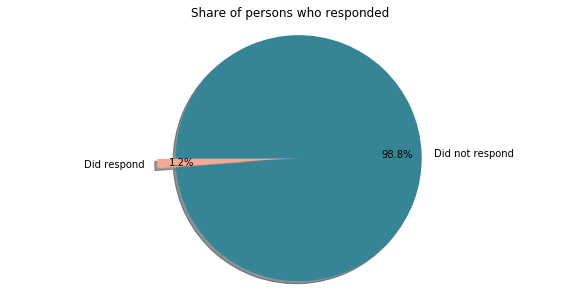

In [137]:
labels = 'Did respond', 'Did not respond'
sizes = [1.2, 98.8]
explode = (0.15, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(figsize=(10,5))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=180, colors = ["#f4a896","#358597"], labeldistance= 1.1, pctdistance=0.8)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Share of persons who responded", size = 12)
plt.savefig("pie.png", bbox_inches = 'tight');

In [109]:
# Create train and test data
X_train, y_train = mailout_train[azdias_new.columns], mailout_train["RESPONSE"]
X_test = mailout_test[azdias_new.columns]

In [110]:
# Label-encode the categorical features
le = preprocessing.LabelEncoder()
#X_df['Sex'] = le.fit_transform(X_df['Sex'])
X_train_X_test = pd.concat([X_train, X_test]).apply(le.fit_transform).reset_index()
X_train = X_train_X_test.iloc[:len(X_train), :]
X_test = X_train_X_test.loc[len(X_train):, :]
X_train.drop("index", inplace = True, axis = 1)
X_test.drop("index", inplace = True, axis = 1)
#X_train, y_train = mailout_train[azdias_new.columns].astype(str), mailout_train["RESPONSE"]
#X_test = mailout_test[azdias_new.columns].astype(str)
#X_train = pd.get_dummies(X_train)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


**In the following a `Randomforestclassifier()` is used. In order to achieve a good result, a hyperparameter optimization is performed using `GridSearchCV()`.**  

- **max_depth:** The maximum depth of the tree
- **n_estimators:** The number of trees in the forest
- **min_samples_leaf:** The minimum number of samples required to be at a leaf node
- **max_leaf_nodes:** Grow trees with `max_leaf_nodes` in best-first fashion
- **min_samples_split:** The minimum number of samples required to split an internal node

In [112]:
gsc = GridSearchCV(estimator=RandomForestClassifier(), 
                   param_grid={#'max_depth': range(3,10),            # default: None
                               'n_estimators': np.arange(40, 100, 10), # default: 100
                               'min_samples_leaf': [1,2,3],          # default: 1
                               #'max_leaf_nodes': range(3,10),       # default: None
                               'min_samples_split': np.arange(2, 10, 3)      # default: 2
                              },
                   cv=5, 
                   scoring= "neg_mean_absolute_error", #'neg_mean_squared_error', 
                   verbose=1,
                   n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.6min finished


{'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 40}


***GridSearchCV* proposes a number of 40 trees to reduce the risk of overfitting. However, one observation per leaf should be allowed, which makes overfitting possible again.**

In [138]:
# Create a DataFrame containing the most important features
feat_import = pd.DataFrame({"Columns": X_train.columns, "Importance": grid_result.best_estimator_.feature_importances_}).sort_values("Importance", ascending = False)[:5]
feat_import

,Columns,Importance
26,CJT_GESAMTTYP,0.049222
34,ONLINE_AFFINITAET,0.048545
22,HH_EINKOMMEN_SCORE,0.047327
38,LP_STATUS_GROB,0.040714
35,RETOURTYP_BK_S,0.039055


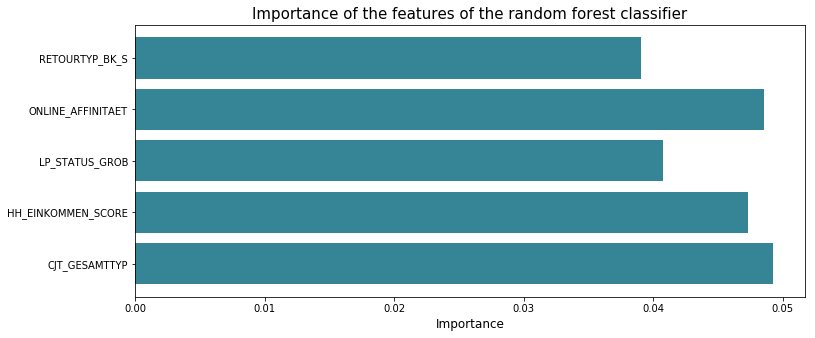

In [150]:
# Matplotlib sorts the bars alphabetically
fig, ax = plt.subplots(figsize=(12,5))
ax.barh(feat_import["Columns"].values, feat_import["Importance"].values, color = "#358597")
#plt.xticks(feat_import["Columns"].values) 
plt.xlabel("Importance", size = 12)
plt.title("Importance of the features of the random forest classifier", size = 15)
plt.savefig("Importance.png", bbox_inches = 'tight');

**It turns out that especially the columns `ONLINE_AFFINITAET`, `HH_INCOME_SCORE` and `CJT_TOTAL TYPE` are considered most important by Random Forest. These three columns deal with the consumption behaviour and income of individuals. This makes sense, because people who have already reacted positively to advertising may react positively again. Especially, something can only be consumed if the necessary money is available.**

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [158]:
# Take a look if the predictions have the same lenght as the test data
len(grid_result.predict_proba(X_test)[:,1])

42833

In [162]:
# calculate probaibilities 
kaggle = pd.DataFrame({"LNR": mailout_test["LNR"].values, "RESPONSE": grid_result.predict_proba(X_test)[:,1]})
kaggle.head()

,LNR,RESPONSE
0,1754,0.000000
1,1770,0.003571
2,1465,0.008333
3,1470,0.000000
4,1478,0.000000


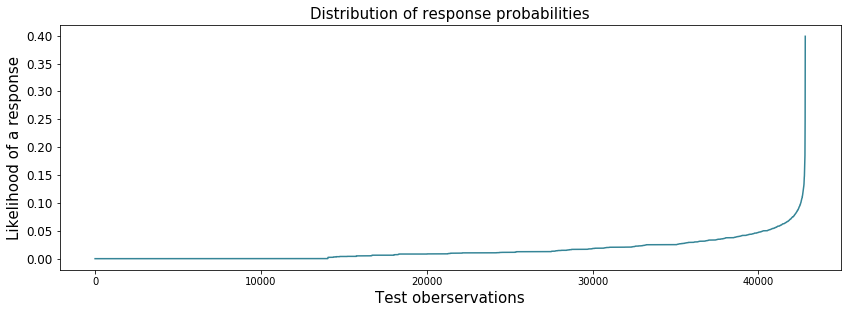

In [180]:
fig, ax = plt.subplots(figsize=(14,4.5))
ax.plot(range(42833), kaggle["RESPONSE"].sort_values(), color = "#358597")
#plt.xticks(range(3,20), size = 18)
plt.xlabel("Test oberservations", size = 15)
plt.ylabel("Likelihood of a response", size = 15)
plt.yticks(size = 12)

plt.title("Distribution of response probabilities", size = 15);

**Since only 1.2% (as already seen above) of the people in the training data set responded, the upper graph makes sense that only a fraction of the test observations differ significantly from 0.**

In [178]:
# max value of the "RESPONSE" column
max(kaggle["RESPONSE"])

0.3988690476190476

In [86]:
# Save as .csv
kaggle.to_csv("kaggle.csv", index = False, header = 1)

### Conclusion
This project was definitely the most difficult for me. The project overview said *"This section will be similar to the corresponding project in Term 1 of the program, but the datasets now include more features that you can potentially use."* However, I found the similarities to be very small. Especially the size of the dataset and finding a "right" cluster method caused me problems. The size of the dataset led to very long waiting times and if you were not careful the workspace would fall asleep and the previous work steps had to be executed from the beginning.

#### Potential improvements
- Better hardware
- Use only a subset of the data (because the data sets are so big) set but use more columns
- Use another Supervised Learning technique for better predictions    

With a better hardware you could have done more work in the same time. Among other things, more hyperparameters could have been evaluated.

#### Findings  
- With 41 features an AUC score between 0.55 and 0.65 can be achieved
- Random forest classifier has with 41 features a higher AUC than with 107. This is probably due to the fact that filling the *NAs* with the Random forest mode is more confusing than helpful. 
- The costs of *k-modes* are very volatile. It is therefore advisable to run it several times to find a stable solution.